In [1]:
import json
import re
import tarfile
from pathlib import Path
from PIL import Image
import torch
from transformers import AutoProcessor, Qwen2_5_VLForConditionalGeneration
from qwen_vl_utils import process_vision_info
from IPython.display import display

def load_dataset(root_path: str):
    """
    Assumes you’ve already extracted:
      ../data/vsp_spatial_planning/train_direct.jsonl
      ../data/vsp_spatial_planning/img/…
    """
    root = Path(root_path)
    jsonl = root / "train_direct.jsonl"
    if not jsonl.exists():
        raise FileNotFoundError(f"train_direct.jsonl not found under {root}")
    examples = []
    with open(jsonl, "r") as f:
        for line in f:
            examples.append(json.loads(line))
    return examples

def extract_boxed_answer(text: str):
    # capture anything inside \boxed{…}, e.g. "DOWN" or "L,L,R,U,D"
    m = re.search(r"\\boxed\{([^}]+)\}", text)
    return m.group(1) if m else None


/home/likelvin/Mirage/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Total examples: 1000

{'text_input': '\nAs a professional maze solver, your task is to analyze a grid-based map and devise an action plan that enables a player to reach the goal from the starting point without falling into any holes, using the fewest possible moves.\n\n## Game Setup\n- The game presents a fully observable grid-based map.\n- The player starts at a specified grid square, with the goal located elsewhere on the map.\n- Each grid square is either safe or contains a hole.\n- Your goal is to guide the player to the goal while avoiding holes.\n- For example, your final answer should be like "L,L,R,U,D", which means an action plan of left, left, right, up, and down.\n\n## Moving Rules\n- The action plan involves a series of moves: \'L\' (left), \'R\' (right), \'U\' (up), or \'D\' (down).\n- Each move transfers the player to the adjacent square in that direction, provided it is a safe square. The player cannot move more than one square at a time.\n- Moving off the edge of the ma

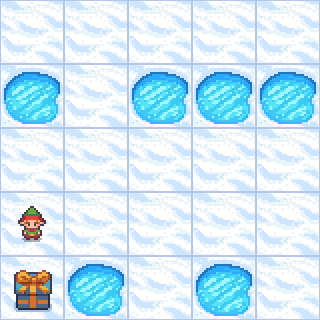

=== HELPER / REASONING PATH MAP ===


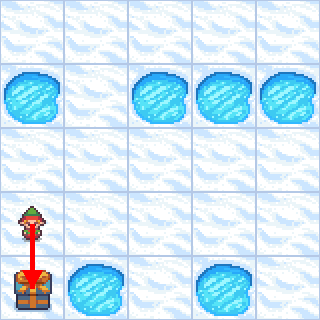

=== RAW text_output ===
\boxed{DOWN} 

=== PARSED BOXED ANSWER ===
DOWN


In [2]:
# --- usage in notebook ---
DATA_DIR = Path("../data/vsp_spatial_planning")
data = load_dataset(DATA_DIR)
print(f"Total examples: {len(data)}\n")

# pick one example
ex = data[0]
print(ex)

# 1) print the prompt
print("=== INPUT TEXT ===")
print(ex["text_input"].strip(), "\n")

# 2) resolve & display the two images
def resolve_img_path(root: Path, json_field: str):
    s = json_field.replace("\\", "")        # drop any stray backslashes
    idx = s.find("img/")
    if idx < 0:
        raise ValueError(f"Expected 'img/' in {json_field}")
    return root / s[idx:]

img_in_path  = resolve_img_path(DATA_DIR, ex["image_input"])
img_out_path = resolve_img_path(DATA_DIR, ex["image_output"])

print("=== INPUT MAP ===")
display(Image.open(img_in_path).convert("RGB"))

print("=== HELPER / REASONING PATH MAP ===")
display(Image.open(img_out_path).convert("RGB"))

# 3) print the raw text_output and the extracted moves
print("=== RAW text_output ===")
print(ex["text_output"], "\n")

print("=== PARSED BOXED ANSWER ===")
print(extract_boxed_answer(ex["text_output"]))

In [ ]:
# the regex we expect: one or more of the four moves,
# comma-separated, optional spaces
MOVE_RE = re.compile(r'^(?:LEFT|RIGHT|UP|DOWN)(?:,\s*(?:LEFT|RIGHT|UP|DOWN))*$')

bad = []
for i, ex in enumerate(data):
    ans = extract_boxed_answer(ex["text_output"] or "")
    if ans is None or not MOVE_RE.match(ans):
        bad.append((i, ex["text_output"], ans))

print(f"Checked {len(data)} examples.")
if not bad:
    print("✅ All boxed answers conform to the MOVE pattern.")
else:
    print(f"⚠️ {len(bad)} examples failed format-check:")
    for idx, raw, parsed in bad[:10]:
        print(f"  • idx={idx:4d}  raw={raw!r}  parsed={parsed!r}")
    if len(bad) > 10:
        print("  …")

In [3]:
device = "cuda:1"

processor = AutoProcessor.from_pretrained("Qwen/Qwen2.5-VL-7B-Instruct")
model     = Qwen2_5_VLForConditionalGeneration.from_pretrained(
    "Qwen/Qwen2.5-VL-7B-Instruct", torch_dtype="auto", device_map=None
).to(device)
model.eval()

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
You have video processor config saved in `preprocessor.json` file which is deprecated. Video processor configs should be saved in their own `video_preprocessor.json` file. You can rename the file or load and save the processor back which renames it automatically. Loading from `preprocessor.json` will be removed in v5.0.
Loading checkpoint shards: 100%|██████████| 5/5 [00:00<00:00, 62.01it/s]


Qwen2_5_VLForConditionalGeneration(
  (model): Qwen2_5_VLModel(
    (visual): Qwen2_5_VisionTransformerPretrainedModel(
      (patch_embed): Qwen2_5_VisionPatchEmbed(
        (proj): Conv3d(3, 1280, kernel_size=(2, 14, 14), stride=(2, 14, 14), bias=False)
      )
      (rotary_pos_emb): Qwen2_5_VisionRotaryEmbedding()
      (blocks): ModuleList(
        (0-31): 32 x Qwen2_5_VLVisionBlock(
          (norm1): Qwen2RMSNorm((1280,), eps=1e-06)
          (norm2): Qwen2RMSNorm((1280,), eps=1e-06)
          (attn): Qwen2_5_VLVisionAttention(
            (qkv): Linear(in_features=1280, out_features=3840, bias=True)
            (proj): Linear(in_features=1280, out_features=1280, bias=True)
          )
          (mlp): Qwen2_5_VLMLP(
            (gate_proj): Linear(in_features=1280, out_features=3420, bias=True)
            (up_proj): Linear(in_features=1280, out_features=3420, bias=True)
            (down_proj): Linear(in_features=3420, out_features=1280, bias=True)
            (act_fn): SiLU()

INPUT MAP:


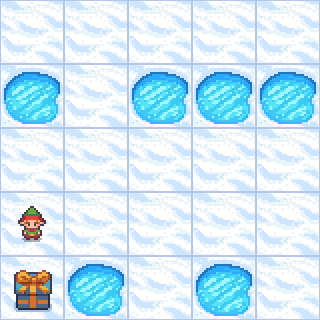

HELPER / REASONING PATH MAP:


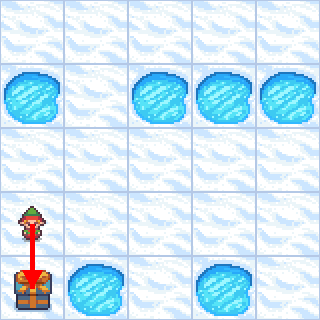

The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


❯❯❯ Model’s raw output:
 system
You are a helpful assistant.
user

As a professional maze solver, your task is to analyze a grid-based map and devise an action plan that enables a player to reach the goal from the starting point without falling into any holes, using the fewest possible moves.

## Game Setup
- The game presents a fully observable grid-based map.
- The player starts at a specified grid square, with the goal located elsewhere on the map.
- Each grid square is either safe or contains a hole.
- Your goal is to guide the player to the goal while avoiding holes.
- For example, your final answer should be like "L,L,R,U,D", which means an action plan of left, left, right, up, and down.

## Moving Rules
- The action plan involves a series of moves: 'L' (left), 'R' (right), 'U' (up), or 'D' (down).
- Each move transfers the player to the adjacent square in that direction, provided it is a safe square. The player cannot move more than one square at a time.
- Moving off the edge of

In [4]:
from IPython.display import display

img1     = Image.open(img_in_path ).convert("RGB")
img2 = Image.open(img_out_path).convert("RGB")

print("INPUT MAP:")
display(img1)

print("HELPER / REASONING PATH MAP:")
display(img2)

messages = [
    {
      "role": "user",
      "content": [
         {"type":"text",
          "text": ex["text_input"].split("Here is the map: ")[0] + "Here is the map: "},
         {"type": "image", "image": img1},    # first <image>
         {"type":"text", "text":"\nHere is my reasoning path: "},
         {"type": "image", "image": img2},    # second <image>
         {"type":"text","text":"Please provide your action plan. The final answer MUST BE put in \\boxed{}."},
      ],
    }
]

prompt = processor.apply_chat_template(
    messages,
    tokenize=False,            
    add_generation_prompt=True 
)

image_inputs, video_inputs = process_vision_info(messages)

inputs = processor(
    text=[prompt],
    images=image_inputs,   
    return_tensors="pt",
    padding=True,
).to(device)

out_ids = model.generate(
    **inputs,
    max_new_tokens = 2000,
    do_sample      = False,
)

raw = processor.decode(out_ids[0], skip_special_tokens=True)
print("❯❯❯ Model’s raw output:\n", raw)

moves = extract_boxed_answer(raw)
print("\n❯❯❯ Parsed moves:", moves)

def normalize_moves(seq: str):
    mapping = {
        'UP':'U','U':'U',
        'DOWN':'D','D':'D',
        'LEFT':'L','L':'L',
        'RIGHT':'R','R':'R'
    }
    tokens = re.split(r'[\s,;]+', (seq or "").strip().upper())
    return [mapping[t] for t in tokens if t in mapping]

pred_moves = normalize_moves(moves)
print("\n❯❯❯ Normalized moves:", pred_moves)

In [1]:
import json
from pathlib import Path

def make_shifted_copy(in_path, out_path, shift=1):
    data = [json.loads(l) for l in open(in_path)]
    # extract the helper-image field values
    helpers = [ex["image_output"] for ex in data]
    # cyclic shift
    shifted = helpers[shift:] + helpers[:shift]

    with open(out_path, "w", encoding="utf-8") as f:
        for ex, wrong_helper in zip(data, shifted):
            ex_copy = ex.copy()
            ex_copy["image_output"] = wrong_helper
            f.write(json.dumps(ex_copy, ensure_ascii=False) + "\n")


make_shifted_copy(
    in_path  = "../data/vsp_spatial_planning/train_direct.jsonl",
    out_path = "../data/vsp_spatial_planning/train_direct_shifted_helpers.jsonl",
    shift    = 500,
)
